# SVM classifier from scratch
In this project, I wrote a code to train a support vector machine classifier from scratch. The only advanced tool that I have used is scipy.optimize, necessary to minimize the loss function numerically.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize 
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
import math
from sklearn.metrics import accuracy_score

The SVM is defined by two classes. $\texttt{SVM_binary}$ is a binary classifier, taking $y \in \{-1, 1\}$. Then $\texttt{multiclass_SVM}$ takes arbitrary number of classes $y \in \mathbf{N}$. $\texttt{multiclass_SVM}$ works by calling $\texttt{SVM_binary}$ $\frac{c(c-1)}{2}$ times, where $c$ is a number of different classes. Then, so called 1 VS 1 classification is performed. Having $\frac{c(c-1)}{2}$ classifiers trained, the new point is classified by each of them and final classification is simply a majority vote of all classifiers. 

The program can work with two kernels, gaussian and linear. 

The classifier minimizes the loss in the form of Lagrangian dual
$$ \max_v \sum_{i=1}^n v_i-\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^nv_iy_i\kappa(x_i,x_j)v_jy_j$$
$$ \textrm{subject to} \sum_{i=1}^nv_iy_i=0 \textrm{  and  } 0 \leq v \leq C$$

Then, the classifier is given by 
$$\textrm{sgn}(g(x))$$
where 
$$g(x)=a_0+\sum_{i=1}^nv_iy_i\kappa(x_i,x)$$
and $a_0$ is calculated as 
$$\frac{1}{|J|}\sum_{j \in J}\left(y_j - \sum_{i=1}^ny_iv_i\kappa(x_i,x_j)\right)$$
where $J=\{v_i: v_i\in (0,C)\}$

$\texttt{K_function(self,x)}$ works for a classifier trained using $X=\left[x_1,\ldots,x_n\right]$, takes a new argument $x$ to be classified and returns a vector of scalar products $\kappa(x_1,x),\ldots,\kappa(x_n,x)$

In [2]:
class SVM_binary: #assuming y is either -1 or 1
    def __init__(self, kernel='linear', C=1, gamma='auto'): #C and gamma have the same function as in sklearn.SVC
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        
    def K_function(self,x):
        if(self.kernel=='linear'): return self.X@x
        if(self.kernel=='rbf'): return np.exp(-self.rbf_gamma*np.power(distance_matrix(self.X,x.reshape((1,x.size)))[:,0],2))
            
    def fit(self,X,y):    
        def gram_matrix(): #calculates gram matrix
            if(self.kernel=='linear'): return np.array(X@X.T)
            if(self.kernel=='rbf'):
                if(self.gamma=='auto'): self.rbf_gamma=1/p
                else: self.rbf_gamma=self.gamma
                return np.array(np.exp(-self.rbf_gamma*np.power(distance_matrix(X,X),2)))

        def optim_problem(v):  #loss function to be optimized
            v_F=np.matrix(v)
            return -float((np.matrix.sum(v_F))-v_F@K_hat@v_F.T/2)

        n=len(y) #number of observarions
        p=X.shape[1] #number of dimensions
        y_F=y.reshape((n,1))
        K=gram_matrix()
        K_hat=y_F*y_F.T*K
        bounds = Bounds(np.repeat(0,n), np.repeat(self.C,n)) #optimization constraints
        linear_constraint = LinearConstraint(y_F.T,0, 0) #optimization constraints
        
        #return support vectors by minimizing loss function
        self.V=minimize(optim_problem, np.repeat(0,n),method='trust-constr',constraints=linear_constraint,
                 options={'verbose': 0}, bounds=bounds).x

        #calculating a0
        SV_indices=np.where(self.V>=0.00001)[0] #due to the numeric optimization, vectors smaller than a treshhold are treated as zeros
        SVs=self.V[SV_indices]
        J_indices=np.where((self.V>=0.00001) & (self.V<=self.C-0.00001))[0] #J are used to approximate a0 as an average
        self.a0=0
        for j in J_indices:
            t_sum=0
            for i in SV_indices:
                t_sum+=self.V[i]*y[i]*K[i,j]
            self.a0+=y[j]-t_sum
        self.a0/=J_indices.size
        
        self.y=y
        self.X=X

    def predict(self,X):
        def g_preclassifier(x): return self.a0+np.sum(self.y*self.V*self.K_function(x))
        prediction=np.array([])
        for i in range(X.shape[0]):
            prediction=np.append(prediction,math.copysign(1,g_preclassifier(X[i,:])))
        return prediction

In [3]:
class multiclass_SVM: #arbitrary y
    def __init__(self, kernel='linear', C=1, gamma='auto'):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        
    def fit(self,X,y):
        self.classes=np.array(list(set(y))) #stores set of different y
        self.set_of_clf=[] #stores all binary classifiers
        self.class_pairs=np.zeros(shape=(0,2)) #stores a history of comparisons made
        
        #this loop compares all possible pairs of classes
        for i in range(self.classes.size):
            for j in range(i+1,self.classes.size):
                index_plus=self.classes[i] #this class is now "-1 class"
                index_minus=self.classes[j] #this class is now "+1 class"
                
                #new_X and new_Y are subsets of X and y used for binary comparison
                new_X=np.vstack((X[np.where(y==index_plus)[0],:],X[np.where(y==index_minus)[0],:]))
                new_y=np.concatenate((np.repeat(1,np.where(y==index_plus)[0].size),np.repeat(-1,np.where(y==index_minus)[0].size)))
                
                clf=SVM_binary(kernel=self.kernel,C=self.C,gamma=self.gamma)
                clf.fit(new_X,new_y)
                self.set_of_clf.append(clf)
                self.class_pairs=np.vstack((self.class_pairs,np.array((self.classes[i],self.classes[j])))) 
                
    def predict(self, X): #assuming classes of X are a subset of classes used previously for training
        n=X.shape[0]
        
        #temp_pairs stores pairs of categories compared by each binary classifier
        temp_pairs_matrix=np.zeros(shape=(0,2))
        for i in range(self.classes.size):
            for j in range(i+1,self.classes.size):
                temp_pairs_matrix=np.vstack((temp_pairs_matrix,(i,j)))
        
        #matrix of predictions counts how many times each new x is classified to each category by all binary classifiers
        matrix_of_predictions=np.zeros(shape=(n,len(self.classes)))
        for i in range(len(self.set_of_clf)):
            prediction=self.set_of_clf[i].predict(X)
            matrix_of_predictions[np.where(prediction==-1)[0],int(temp_pairs_matrix[i,1])]+=1
            matrix_of_predictions[np.where(prediction==1)[0],int(temp_pairs_matrix[i,0])]+=1
        prediction=np.array([]) #final vector to be returned
        for i in range(n):
            index=np.where(matrix_of_predictions[i,:]==np.max(matrix_of_predictions[i,:]))[0][0] #for each x choosing class which has the most votes
            prediction=np.append(prediction,self.classes[index])
        return prediction

### Binary linear classification - hard margin

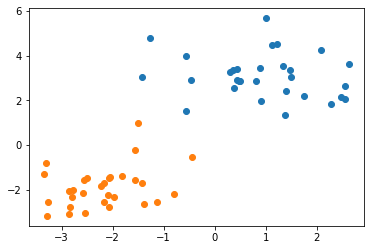

In [4]:
#creating and plotting the data set
x_1=np.random.multivariate_normal([1,3], [[1,0],[0,1]], size=30) 
x_2=np.random.multivariate_normal([-2,-2], [[1,0],[0,1]], size=30) 
plt.scatter(np.array(x_1[:,0]),np.array(x_1[:,1]))
plt.scatter(np.array(x_2[:,0]),np.array(x_2[:,1]))
plt.show()
X=np.vstack((x_1,x_2))
y=np.concatenate((np.repeat(-1,30),np.repeat(1,30)))
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [7]:
#training the classifier
clf=SVM_binary(C=np.inf)
clf.fit(X_train,y_train)

In [10]:
#printing the result of classification
print(clf.predict(X_test))
#printing accuracy score
print(accuracy_score(y_test, clf.predict(X_test)))

[-1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1.]
1.0


### Binary linear classification - soft margin - different regularization parameters C

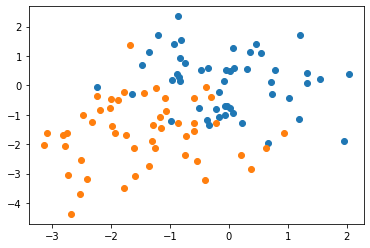

In [11]:
x_1=np.random.multivariate_normal([0,0], [[1,0],[0,1]], size=50) 
x_2=np.random.multivariate_normal([-1.5,-1.5], [[1,0],[0,1]], size=50) 
plt.scatter(np.array(x_1[:,0]),np.array(x_1[:,1]))
plt.scatter(np.array(x_2[:,0]),np.array(x_2[:,1]))
plt.show()
X=np.vstack((x_1,x_2))
y=np.concatenate((np.repeat(-1,50),np.repeat(1,50)))
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [12]:
#training classifiers with different regularization parameters
clf0_001=SVM_binary(C=0.001)
clf0_01=SVM_binary(C=0.01)
clf0_1=SVM_binary(C=0.1)
clf1=SVM_binary()
clf0_001.fit(X_train,y_train)
clf0_01.fit(X_train,y_train)
clf0_1.fit(X_train,y_train)
clf1.fit(X_train,y_train)

In [13]:
print(accuracy_score(y_test, clf0_001.predict(X_test)))
print(accuracy_score(y_test, clf0_01.predict(X_test)))
print(accuracy_score(y_test, clf0_1.predict(X_test)))
print(accuracy_score(y_test, clf1.predict(X_test)))

0.72
0.8
0.84
0.8


### Multiclass radial basis kernel classification

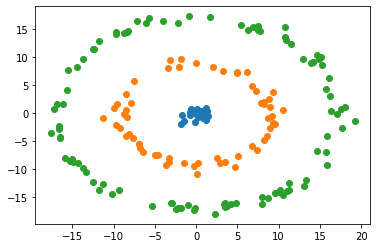

In [31]:
x_1=np.random.multivariate_normal([0,0], [[1,0],[0,1]], size=20) 
x_2=np.random.multivariate_normal([0,0], [[1,0],[0,1]], size=60) 
x_3=np.random.multivariate_normal([0,0], [[1,0],[0,1]], size=100)
x_2=8*x_2/np.matrix((np.linalg.norm(x_2,axis=1))).T+1*x_2
x_3=16*x_3/np.matrix((np.linalg.norm(x_3,axis=1))).T+1*x_3

plt.scatter(np.array(x_1[:,0]),np.array(x_1[:,1]))
plt.scatter(np.array(x_2[:,0]),np.array(x_2[:,1]))
plt.scatter(np.array(x_3[:,0]),np.array(x_3[:,1]))
plt.show()

X=np.vstack((x_1,x_2,x_3))
y=np.concatenate((np.repeat(1,20),np.repeat(6,60),np.repeat(2,100)))
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [32]:
clf=multiclass_SVM(kernel='rbf',C=np.inf)
clf.fit(X_train,y_train)

In [33]:
accuracy_score(y_test,clf.predict(X_test))

1.0